In [14]:
import sys
import os
import configparser
import csv
import copy
import numpy as np
import imageio
import torch
import torchvision
import matplotlib.pyplot as plt
import skimage.transform
from sklearn.metrics import roc_curve, auc
from RetinaCheckerPandas import RetinaCheckerPandas, single_output_performance
from helper_functions import reduce_to_2_classes, AverageMeter, AccuracyMeter
from make_default_config import get_config


In [15]:
# parameter
config = get_config()
config['network']['model'] = 'inception_v3'
config['network']['pretrained'] = 'False'
config['network']['optimizer'] = 'Adam'
config['network']['criterion'] = 'BCEWithLogitsLoss'
config['network']['multiclass'] = 'True'

config['files']['test file'] = 'D:/Dropbox/Data/cropped-outer-test/testlabels.csv'
config['files']['test root'] = 'D:/Dropbox/Data/cropped-outer-test/'
config['files']['image size'] = '299'
config['input']['checkpoint'] = 'd:/ckpt/model_181120_kaggle.ckpt'
config['input']['evaluation only'] = 'True'

number_sample_images = 36
max_batch_size = 16
num_workers = 2

In [16]:
rc = RetinaCheckerPandas()

rc.initialize( config )

Using device cpu


In [17]:
# Loading data sets based on configuration
rc.load_datasets()

# Initializing sampler and data (=patch) loader
rc.create_dataloader(num_workers)

# Initialize the model
rc.initialize_model()
rc.initialize_criterion()
rc.initialize_optimizer()

In [18]:
rc.load_state()

=> loaded checkpoint 'd:/ckpt/model_181120_kaggle.ckpt' (epoch 50)


In [19]:
test_loader = torch.utils.data.DataLoader(dataset=rc.test_dataset,
                                        batch_size=min(len(rc.test_dataset), max_batch_size),
                                        shuffle=True,
                                        sampler=None)

In [20]:
all_outputs = np.zeros((len(rc.test_dataset), len(rc.classes)))
all_labels = np.zeros_like(all_outputs)

In [21]:
rc.test_dataset

Dataset PandasDataset
    Number of datapoints: 150
    Root Location: D:/Dropbox/Data/cropped-outer-test/
    Transforms (if any): Compose(
                             Resize(size=328, interpolation=PIL.Image.BILINEAR)
                             CenterCrop(size=(299, 299))
                             ToTensor()
                         )
    Target Transforms (if any): None

In [22]:
saved = torch.load(config['input']['checkpoint'], map_location='cpu')

train_loss = saved['train_loss']
train_accuracy = saved['train_accuracy']
test_loss = saved['test_loss']
test_accuracy = saved['test_accuracy']
test_confusion = saved['test_confusion']
classes = saved['classes']
del(saved)

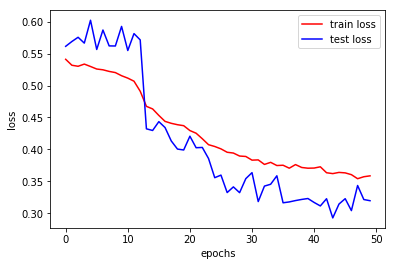

In [23]:
plt.plot(train_loss.numpy(), 'r', label='train loss')
plt.plot(test_loss.numpy(), 'b', label='test loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.xticks(np.arange(0,train_loss.size(0)+1, 10))
plt.show()

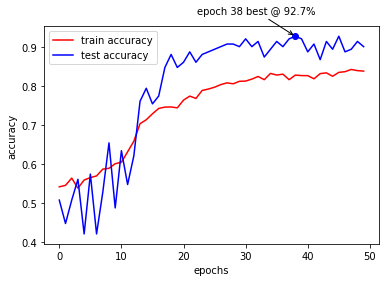

In [24]:
best_epoch = int(np.argmax(test_accuracy.numpy()))
max_accuracy = np.max(test_accuracy.numpy())

plt.plot(train_accuracy.numpy(), 'r', label='train accuracy')
plt.plot(test_accuracy.numpy(), 'b', label='test accuracy')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.xticks(np.arange(0,train_accuracy.size(0)+1, 10))
plt.plot(best_epoch, max_accuracy, 'bo')
plt.annotate(
        'epoch {} best @ {:.1f}%'.format(best_epoch, max_accuracy*100),
        xy=(best_epoch, max_accuracy), xytext=(20, 20),
        textcoords='offset points', ha='right', va='bottom',
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
plt.show()

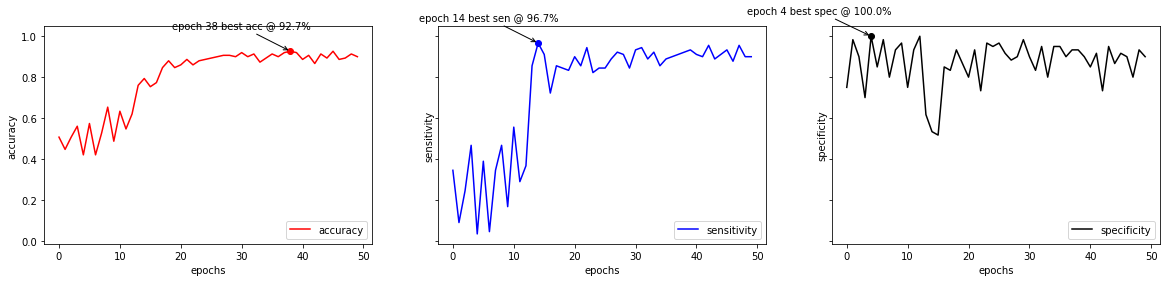

Best accuracy in epoch 38 with accuracy 92.7%, sensitivity 92.2%, specificity 93.3%
Best sensitivity in epoch 14 with accuracy 79.3%, sensitivity 96.7%, specificity 53.3%
Best specificity in epoch 4 with accuracy 42.0%, sensitivity 3.3%, specificity 100.0%


In [25]:
specificity = np.zeros_like(test_accuracy)
sensitivity = np.zeros_like(test_accuracy)
accuracy = np.zeros_like(test_accuracy)
for ii in range(specificity.size):
    confusion_2class = test_confusion[ii,:,:]
    accuracy[ii] = np.diag(confusion_2class).sum()/confusion_2class.sum()
    sensitivity[ii] = confusion_2class[1,1]/confusion_2class[:,1].sum()
    specificity[ii] = confusion_2class[0,0]/confusion_2class[:,0].sum()

max_acc = np.max(accuracy)
best_acc = np.argmax(accuracy)
max_sen = np.max(sensitivity)
best_sen = np.argmax(sensitivity)
max_spe = np.max(specificity)
best_spe = np.argmax(specificity)


ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(20,4))

ax[1][0].plot(accuracy, 'r', label='accuracy')
ax[1][0].plot(best_acc, max_acc, 'ro')
ax[1][0].annotate(
        'epoch {} best acc @ {:.1f}%'.format(best_acc, max_acc*100),
        xy=(best_acc, max_acc), xytext=(20, 20),
        textcoords='offset points', ha='right', va='bottom',
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
ax[1][0].legend(loc='lower right')
ax[1][0].set_ylabel('accuracy')
ax[1][0].set_xlabel('epochs')
ax[1][0].set_xticks(np.arange(0,accuracy.size+1, 10))

ax[1][1].plot(sensitivity, 'b', label='sensitivity')
ax[1][1].plot(best_sen, max_sen, 'bo')
ax[1][1].annotate(
        'epoch {} best sen @ {:.1f}%'.format(best_sen, max_sen*100),
        xy=(best_sen, max_sen), xytext=(20, 20),
        textcoords='offset points', ha='right', va='bottom',
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
ax[1][1].legend(loc='lower right')
ax[1][1].set_xlabel('epochs')
ax[1][1].set_ylabel('sensitivity')
ax[1][1].set_xticks(np.arange(0,accuracy.size+1, 10))

ax[1][2].plot(specificity, 'k', label='specificity')
ax[1][2].plot(best_spe, max_spe, 'ko')
ax[1][2].annotate(
        'epoch {} best spec @ {:.1f}%'.format(best_spe, max_spe*100),
        xy=(best_spe, max_spe), xytext=(20, 20),
        textcoords='offset points', ha='right', va='bottom',
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
ax[1][2].legend(loc='lower right')
ax[1][2].set_xticks(np.arange(0,accuracy.size+1, 10))
ax[1][2].set_ylabel('specificity')
ax[1][2].set_xlabel('epochs')
plt.show()

print('Best accuracy in epoch {} with accuracy {:.1f}%, sensitivity {:.1f}%, specificity {:.1f}%'.format(
       best_acc, accuracy[best_acc]*100, sensitivity[best_acc]*100, specificity[best_acc]*100))
print('Best sensitivity in epoch {} with accuracy {:.1f}%, sensitivity {:.1f}%, specificity {:.1f}%'.format(
       best_sen, accuracy[best_sen]*100, sensitivity[best_sen]*100, specificity[best_sen]*100))
print('Best specificity in epoch {} with accuracy {:.1f}%, sensitivity {:.1f}%, specificity {:.1f}%'.format(
       best_spe, accuracy[best_spe]*100, sensitivity[best_spe]*100, specificity[best_spe]*100))

In [26]:
rc.model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    losses = AverageMeter()
    accuracy = AccuracyMeter()

    confusion = torch.zeros((2, 2), dtype=torch.float)
    confusion_old = torch.zeros((5, 5), dtype=torch.float)
    counter = 0
    
    for images, labels in test_loader:
        print('.', end='', flush=True)
        images = images.to(rc.device)
        labels = labels.to(rc.device)

        outputs = rc.model(images)
        loss = rc.criterion(outputs, labels)
        
        all_outputs[counter:counter+len(images), :] = outputs
        all_labels[counter:counter+len(images), :] = labels
        counter += len(images)

        losses.update(loss.item(), images.size(0))

        num_correct = single_output_performance( labels, outputs )

        accuracy.update(num_correct, labels.size(0))
        predicted = torch.nn.Sigmoid()(outputs)
        
        for pred, lab in zip(predicted[:,5].round().cpu().numpy().astype(np.int), labels[:,5].cpu().numpy().astype(np.int)):
            confusion[pred, lab] += 1
        for pred, lab in zip(predicted[:,:5].argmax(1), labels[:,:5].argmax(1)):
            confusion_old[pred, lab] += 1


..........

In [27]:
print('Test Accuracy of the model on the {} test images: {} %'.format(accuracy.count, accuracy.avg*100))
print('Classes: {}'.format(5))
print('Confusion matrix:\n', (confusion_old))

confusion_2class = confusion
print('Accuracy: {:.1f}%'.format(np.diag(confusion_2class).sum()/confusion_2class.sum()*100))
print(confusion_2class)
print('Sensitivity: {:.1f}%'.format(confusion_2class[1,1]/confusion_2class[:,1].sum()*100))
print('Specificity: {:.1f}%'.format(confusion_2class[0,0]/confusion_2class[:,0].sum()*100))

Test Accuracy of the model on the 150 test images: 90.0 %
Classes: 5
Confusion matrix:
 tensor([[26., 12.,  4.,  1.,  0.],
        [ 4., 14.,  4.,  0.,  0.],
        [ 0.,  4., 20., 19.,  1.],
        [ 0.,  0.,  0.,  9., 16.],
        [ 0.,  0.,  2.,  1., 13.]])
Accuracy: 90.0%
tensor([[54.,  9.],
        [ 6., 81.]])
Sensitivity: 90.0%
Specificity: 90.0%


In [28]:
from sklearn.model_selection import StratifiedShuffleSplit
max_samples = min(len(rc.test_dataset), number_sample_images)

if max_samples < len(rc.test_dataset):
    sss = StratifiedShuffleSplit(n_splits=1, test_size=max_samples)
    sampling_index = next(iter(sss.split(rc.test_dataset.filenames, rc.test_dataset.targets)))[1]
else:
    sampling_index = np.arange(len(rc.test_dataset), dtype=np.int)

In [29]:
dataset = rc.test_dataset.subset(sampling_index)
test_loader = torch.utils.data.DataLoader(dataset=dataset,
                                    batch_size=min(len(dataset), max_batch_size),
                                    shuffle=False,
                                    sampler=None)

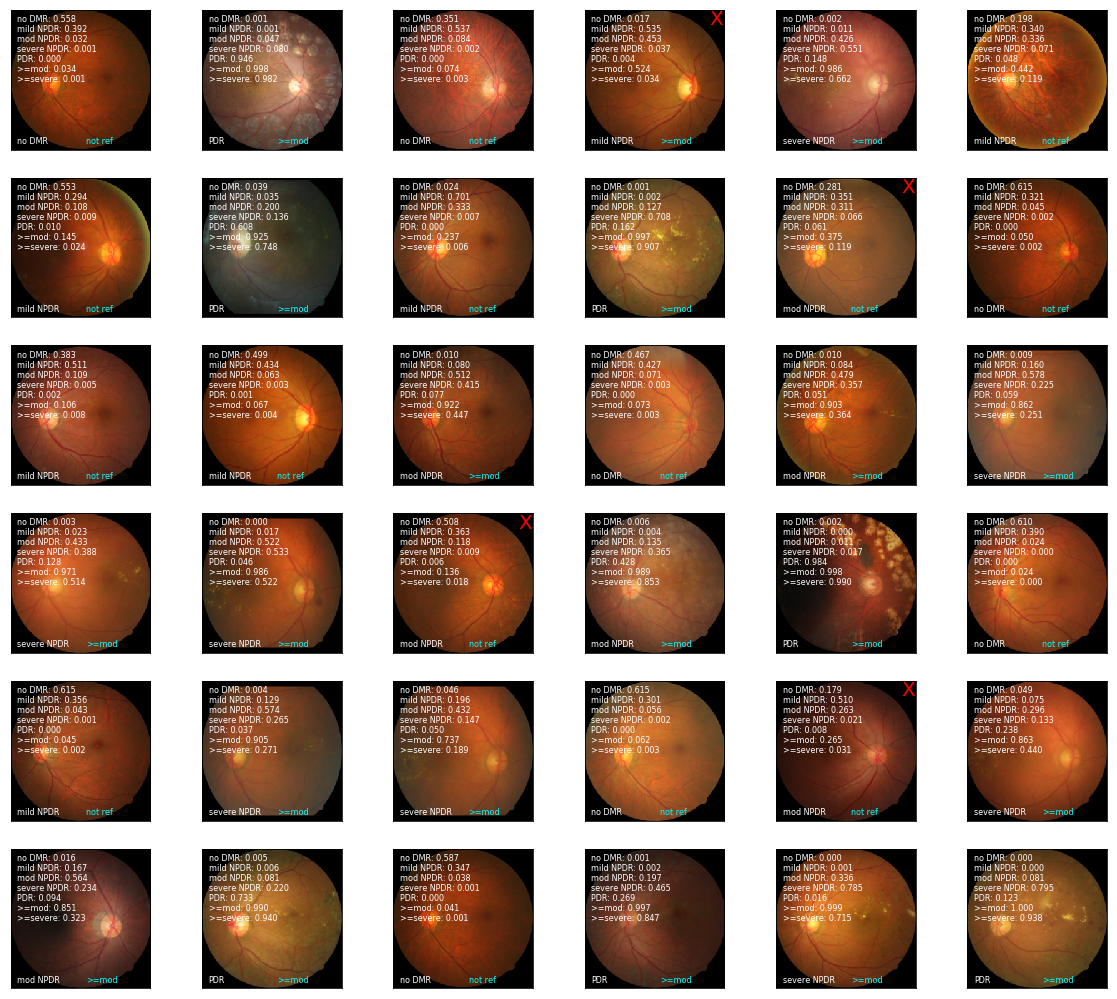

In [30]:
font_size = 8
if number_sample_images > 0:  
    n_cols = 6
    n_rows = np.ceil(number_sample_images/n_cols)
    classlabel = ['no DMR', 'mild NPDR', 'mod NPDR', 'severe NPDR', 'PDR', '>=mod', '>=severe']
    fig, ax = plt.subplots(int(n_rows), int(n_cols), True, True, figsize=(20,int(n_rows)*3))
    counter = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(rc.device)
            labels = labels.to(rc.device)

            outputs = rc.model(images)

            for img, lab, out in zip(images, labels, outputs):
                ii = int(counter/n_cols)
                jj = int(counter%n_cols)
                img_array = skimage.transform.resize(imageio.imread(dataset.filenames[counter]), (224,224), mode='constant', anti_aliasing=True)
                ax[ii, jj].imshow(img_array, origin='lower')
                ax[ii, jj].annotate( classlabel[lab[:5].argmax()], xy=(10,10), color='white', size=font_size)
                prediction = torch.nn.Sigmoid()(out)
                if prediction[5] > 0.5:
                    ax[ii, jj].annotate( '>=mod', xy=(120,10), color='cyan', size=font_size)
                else:
                    ax[ii, jj].annotate( 'not ref', xy=(120,10), color='cyan', size=font_size)
                if (lab[:5].argmax() < 2 and prediction[5] >= 0.5) or (lab[:5].argmax() >= 2 and prediction[5] < 0.5):
                    ax[ii, jj].annotate( 'X', xy=(200,200), color='red', size=20)
                for cc in range(7):
                    ax[ii, jj].annotate( '{}: {:.3f}'.format(classlabel[cc], prediction[cc]) , xy=(10,205-cc*2*font_size), color='white', size=font_size)
                counter+=1

    plt.xticks([])
    plt.yticks([])

In [31]:
y_test = all_labels
y_score = all_outputs
n_classes = 7

In [32]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

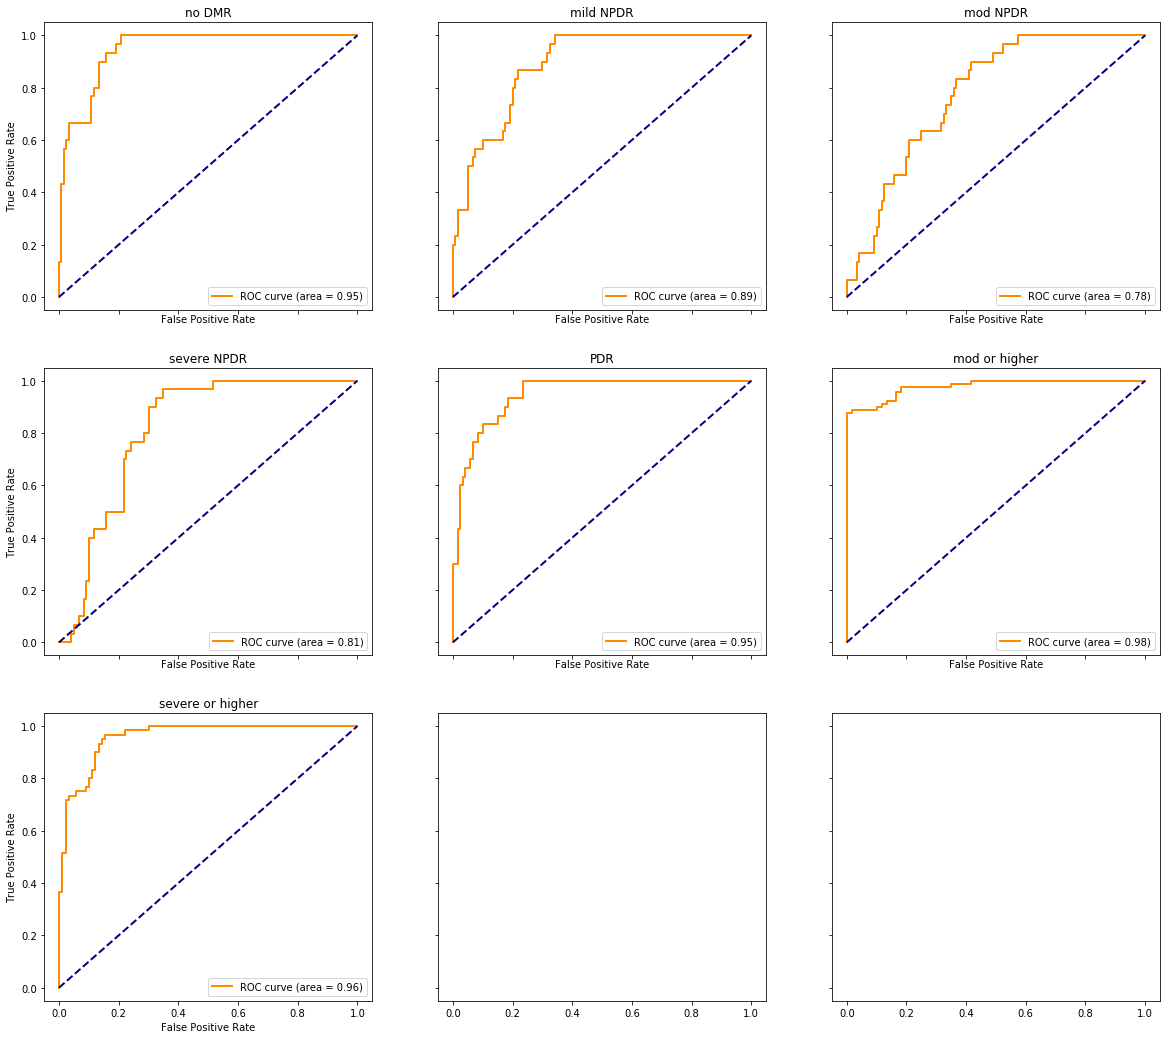

In [33]:
n_cols = 3
n_rows = int(np.ceil(n_classes/n_cols))
fig, ax = plt.subplots(n_rows, n_cols, True, True, figsize=(20,6*n_rows))
lw = 2
for ii in range(n_classes):
    row = int(ii/n_cols)
    col = int(ii%n_cols)
    ax[row, col].plot(fpr[ii], tpr[ii], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[ii])
    ax[row, col].plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax[row, col].set_xlim([-0.05, 1.05])
    ax[row, col].set_ylim([-0.05, 1.05])
    ax[row, col].set_xlabel('False Positive Rate')
    ax[row, col].legend(loc="lower right")
    ax[row, col].set_title(dataset.classes[ii])
    ax[row, 0].set_ylabel('True Positive Rate')

plt.show()